In [1]:
import os
from dotenv import find_dotenv, load_dotenv
from shapely.ops import orient

load_dotenv(find_dotenv())
src_path = os.environ.get("PROJECT_SRC")
os.chdir(src_path)

src_path

'C:\\Programming\\PyPSA-GB_2030\\PyPSA-GB'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

plt.style.use("ggplot")
import generators
from data_reader_writer import data_writer

# Costing Analysis of 2030 Generation

In [3]:
year = 2030
FES_scenario = "Leading The Way"
FES_year = 2022
euro_to_gbp = 1.20
hours_in_year = 24 * 365

In [4]:
PV: dict[str, float] = {
    "investment": 543.3289 * 1000,  # euro/MW
}

ccgt: dict[str, float] = {
    "investment": 878.324 * 1000,  # euro/MW
    "fuel": 24.568,  # euro/MWh
    "efficiency": 0.58
}

wind_offshore: dict[str, float] = {
    "investment": 1682.1226 * 1000,  # euro/MW
    "ac_station_investment": 264.5554 * 1000,  # euro/MW
}

wind_onshore: dict[str, float] = {
    "investment": 1095.8533 * 1000,  # euro/MW
}

biomass: dict[str, float] = {
    "investment": 2337.6116 * 1000,  # euro/MW
    "fuel": 7.406,  # euro/MWh
    "efficiency": 0.468
}

nuclear: dict[str, float] = {
    "investment": 8594.1354 * 1000,  # euro/MW
    "fuel": 3.41222,  # euro/MWh
    "efficiency": 0.326
}

## FES Data

In [5]:
scenarios = ["Leading The Way", "Consumer Transformation", "System Transformation", "Further Flex and Renewables",
             "New Dispatch"]
scenario_names = ["LTW", "CT", "ST", "FFR", "ND"]
df_generators_2025s: list[pd.DataFrame] = []
df_generators_2030s: list[pd.DataFrame] = []
gen_p_nom_2025s: list[pd.Series] = []
gen_p_nom_2030s: list[pd.Series] = []
difference_fes: list[pd.Series] = []
difference_neso: list[pd.Series] = []
time_step = 1.0

In [6]:
for i in range(len(scenarios[:3])):
    year = 2025
    start = str(year) + "-12-02 00:00:00"
    end = str(year) + "-12-02 03:30:00"
    if year > 2020:
        data_writer(start, end, time_step, year, demand_dataset="eload", year_baseline=2012, scenario=scenarios[i],
                    FES=2022)
    df_generators_2025s.append(pd.read_csv("LOPF_data/generators.csv", index_col=0))

    # 2030
    year = 2030
    start = str(year) + "-12-02 00:00:00"
    end = str(year) + "-12-02 03:30:00"

    data_writer(start, end, time_step, year, demand_dataset="eload", year_baseline=2012, scenario=scenarios[i],
                FES=2022)
    df_generators_2030s.append(pd.read_csv("LOPF_data/generators.csv", index_col=0))

C:\Programming\PyPSA-GB_2030\PyPSA-GB\distance_calculator.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_point = {'lon': df['x'][i], 'lat': df['y'][i]}
C:\Programming\PyPSA-GB_2030\PyPSA-GB\generators.py:795: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df.index = pd.to_datetime(df.index, infer_datetime_format=True)
C:\Programming\PyPSA-GB_2030\PyPSA-GB\distance_calculator.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value

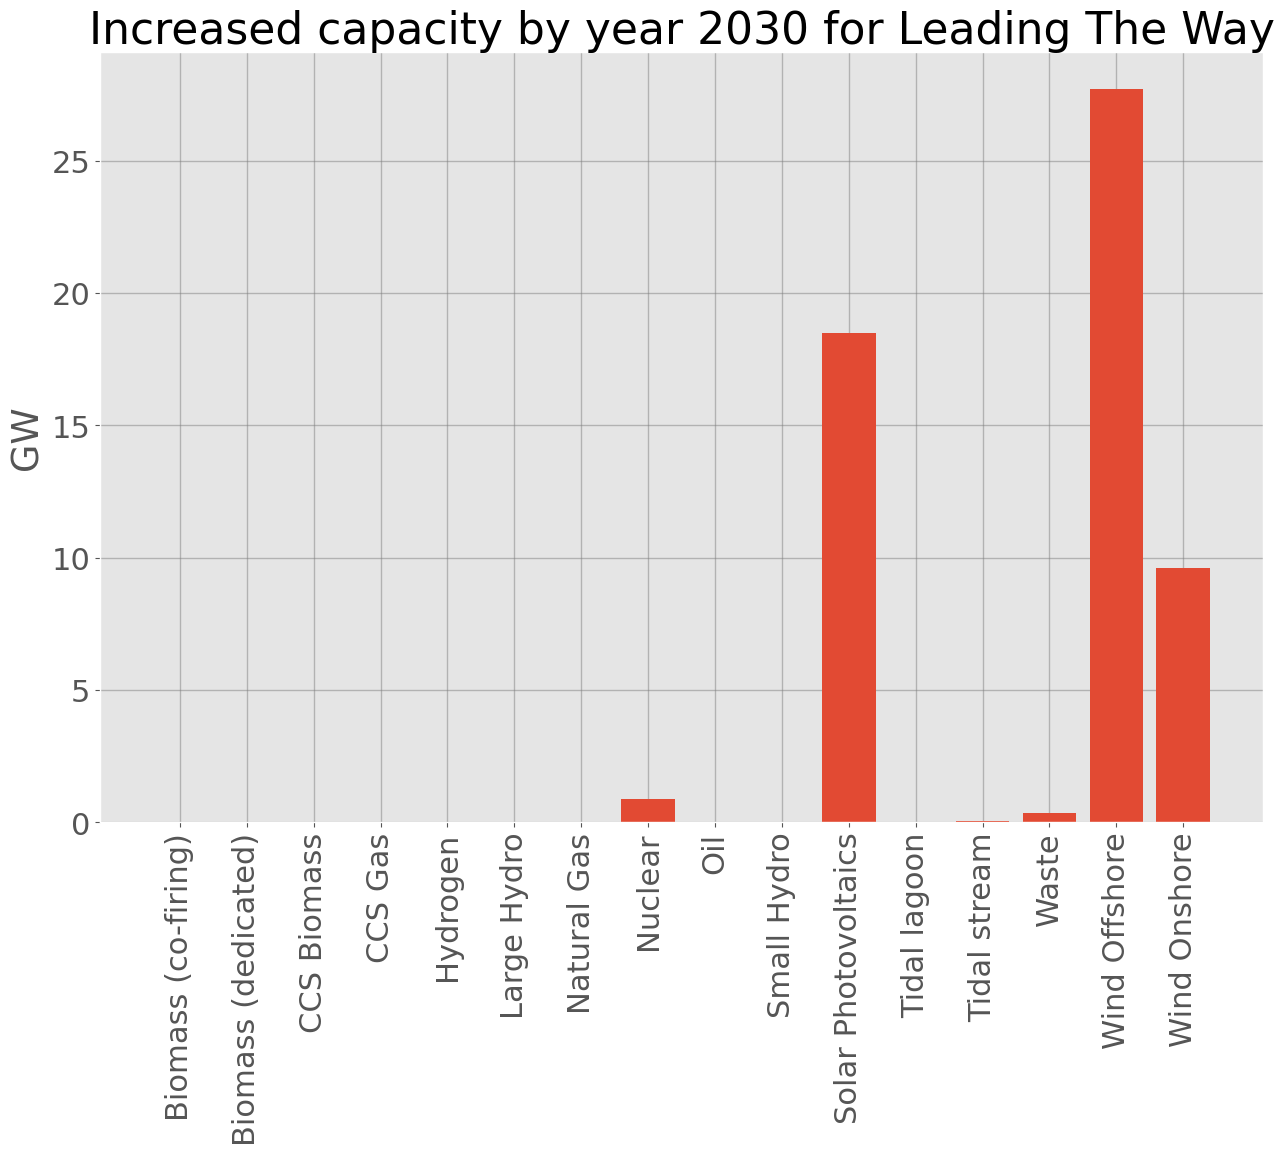

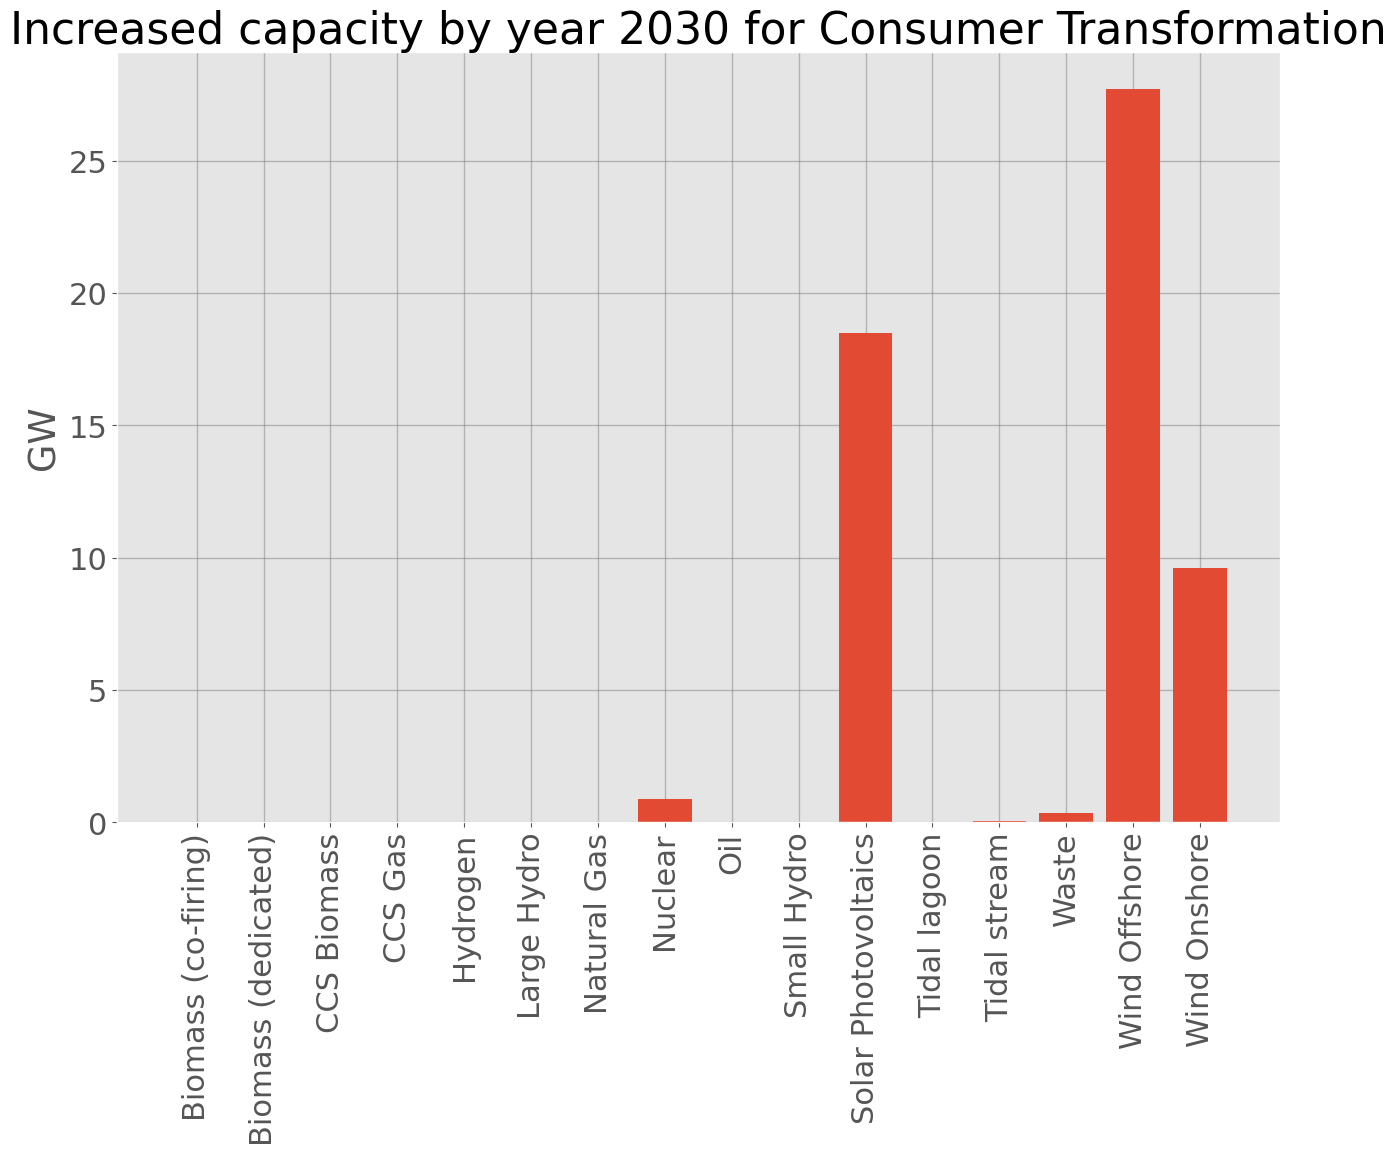

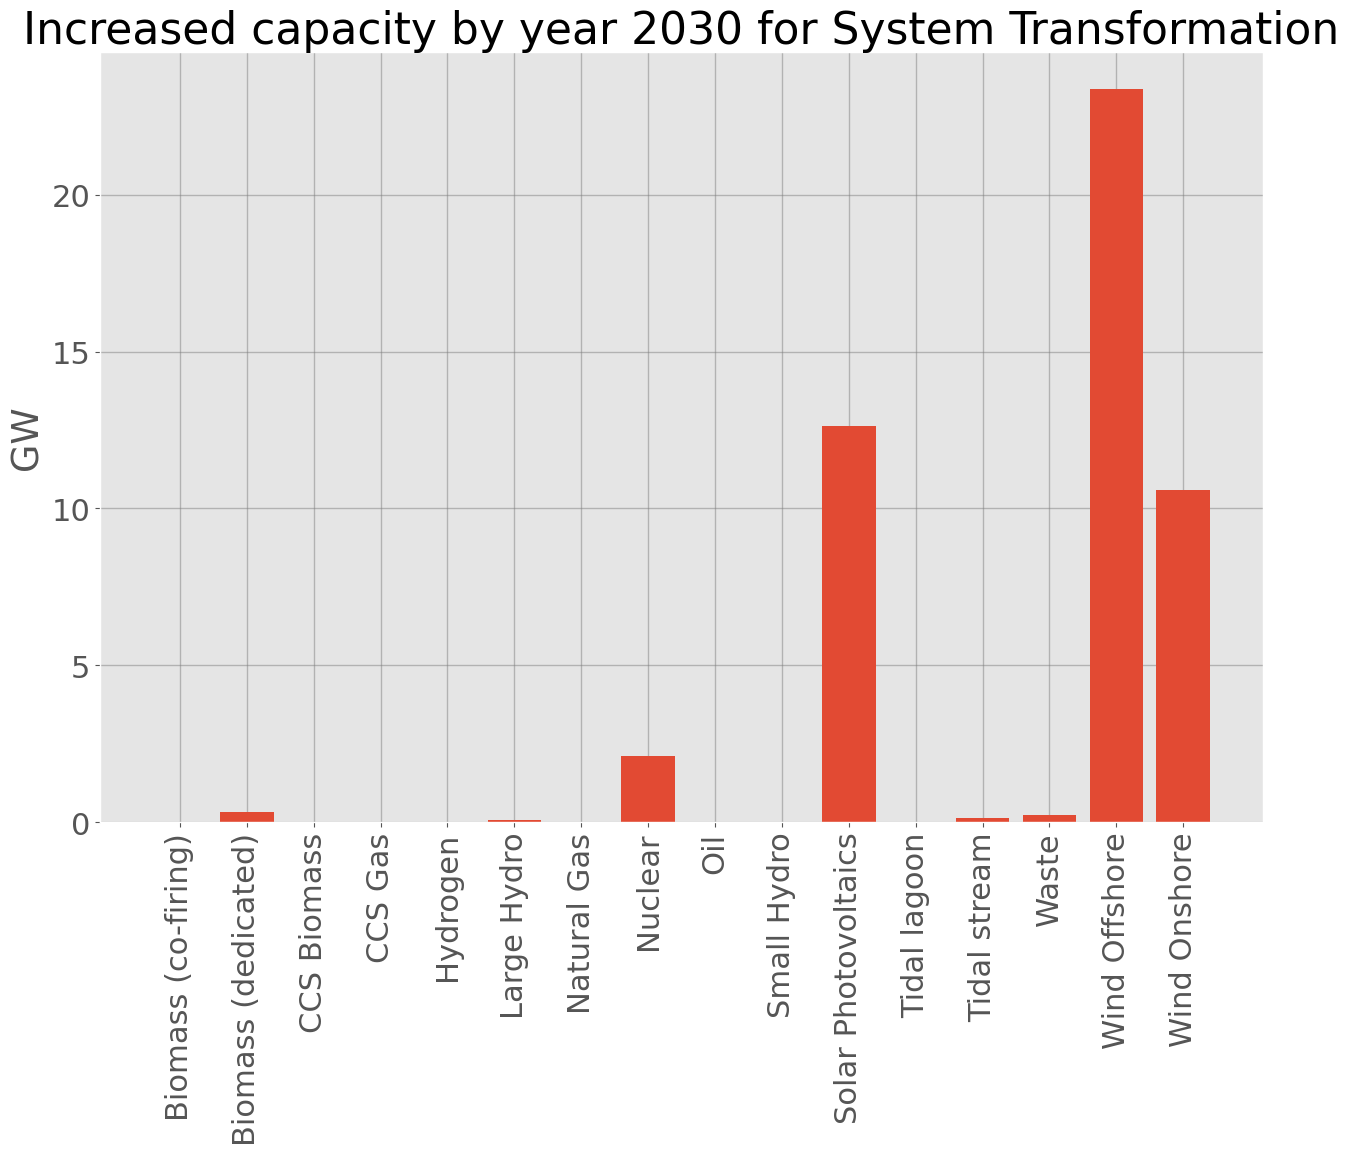

In [8]:
for i in range(len(scenarios[:3])):
    # 2025
    gen_p_nom_2025 = df_generators_2025s[i].p_nom.groupby(df_generators_2025s[i].carrier).sum().sort_values()
    if year > 2020:
        gen_p_nom_2025.drop('Unmet Load', inplace=True)
    gen_p_nom_2025.drop(gen_p_nom_2025[gen_p_nom_2025 < 50].index, inplace=True)

    gen_p_nom_2025s.append(gen_p_nom_2025)

    # 2030
    gen_p_nom_2030 = df_generators_2030s[i].p_nom.groupby(df_generators_2030s[i].carrier).sum().sort_values()
    if year > 2020:
        gen_p_nom_2030.drop('Unmet Load', inplace=True)
    gen_p_nom_2030.drop(gen_p_nom_2030[gen_p_nom_2030 < 50].index, inplace=True)

    gen_p_nom_2030s.append(gen_p_nom_2030)

    # Difference
    difference_gen_p_nom = (gen_p_nom_2030 - gen_p_nom_2025).clip(lower=0.0)
    difference_fes.append(difference_gen_p_nom)

    plt.rcParams.update({"font.size": 22})
    # bar chart
    plt.figure(figsize=(15, 10))
    plt.bar(difference_fes[i].index, difference_fes[i].values / 1000)
    plt.xticks(difference_fes[i].index, rotation=90)
    plt.ylabel("GW")
    plt.grid(color="grey", linewidth=1, axis="both", alpha=0.5)
    plt.title("Increased capacity by year " + str(year) + " for " + scenarios[i])
    plt.savefig(
        "C:/Programming/PyPSA-GB_2030/Clean_Power_Analysis/" + scenario_names[i] + "_increased_capacity_by_year_" + str(
            year) + ".png",
        format="png", bbox_inches='tight')
    plt.savefig(
        "C:/Programming/PyPSA-GB_2030/Clean_Power_Analysis/" + scenario_names[i] + "_increased_capacity_by_year_" + str(
            year) + ".pdf",
        format="pdf", bbox_inches='tight')
    plt.show()

In [9]:
gen_data_ffr: dict[str, float] = {
    "Tidal stream": 0.0,  # MW
    "Small Hydro": 0.0,  # MW
    "Oil": 0.0,  # MW
    "Biomass (co-firing)": 0.0,  # MW
    "Large Hydro": 7.9 * 10 ** 3,  # MW
    "Waste": 0.0,  # MW
    "Nuclear": 3.5 * 10 ** 3,  # MW
    "Biomass (dedicated)": 4.0 * 10 ** 3,  # MW
    "Wind Onshore": 27.3 * 10 ** 3,  # MW
    "Wind Offshore": 50.6 * 10 ** 3,  # MW
    "Solar Photovoltaics": 47.4 * 10 ** 3,  # MW
    "Natural Gas": 35.0 * 10 ** 3,  # MW
}

gen_data_nd: dict[str, float] = {
    "Tidal stream": 0.0,  # MW
    "Small Hydro": 0.0,  # MW
    "Oil": 0.0,  # MW
    "Biomass (co-firing)": 0.0,  # MW
    "Large Hydro": 4.6 * 10 ** 3,  # MW
    "Waste": 0.0,  # MW
    "Nuclear": 4.1 * 10 ** 3,  # MW
    "Biomass (dedicated)": 3.8 * 10 ** 3,  # MW
    "Wind Onshore": 27.3 * 10 ** 3,  # MW
    "Wind Offshore": 47.1 * 10 ** 3,  # MW
    "Solar Photovoltaics": 47.4 * 10 ** 3,  # MW
    "Natural Gas": 35.0 * 10 ** 3,  # MW
}

df_neso_ffr = pd.Series(gen_data_ffr, name="p_nom")
df_neso_ffr.index.name = "carrier"

df_neso_nd = pd.Series(gen_data_nd, name="p_nom")
df_neso_nd.index.name = "carrier"

gen_p_nom_2030s.append(df_neso_ffr)
gen_p_nom_2030s.append(df_neso_nd)

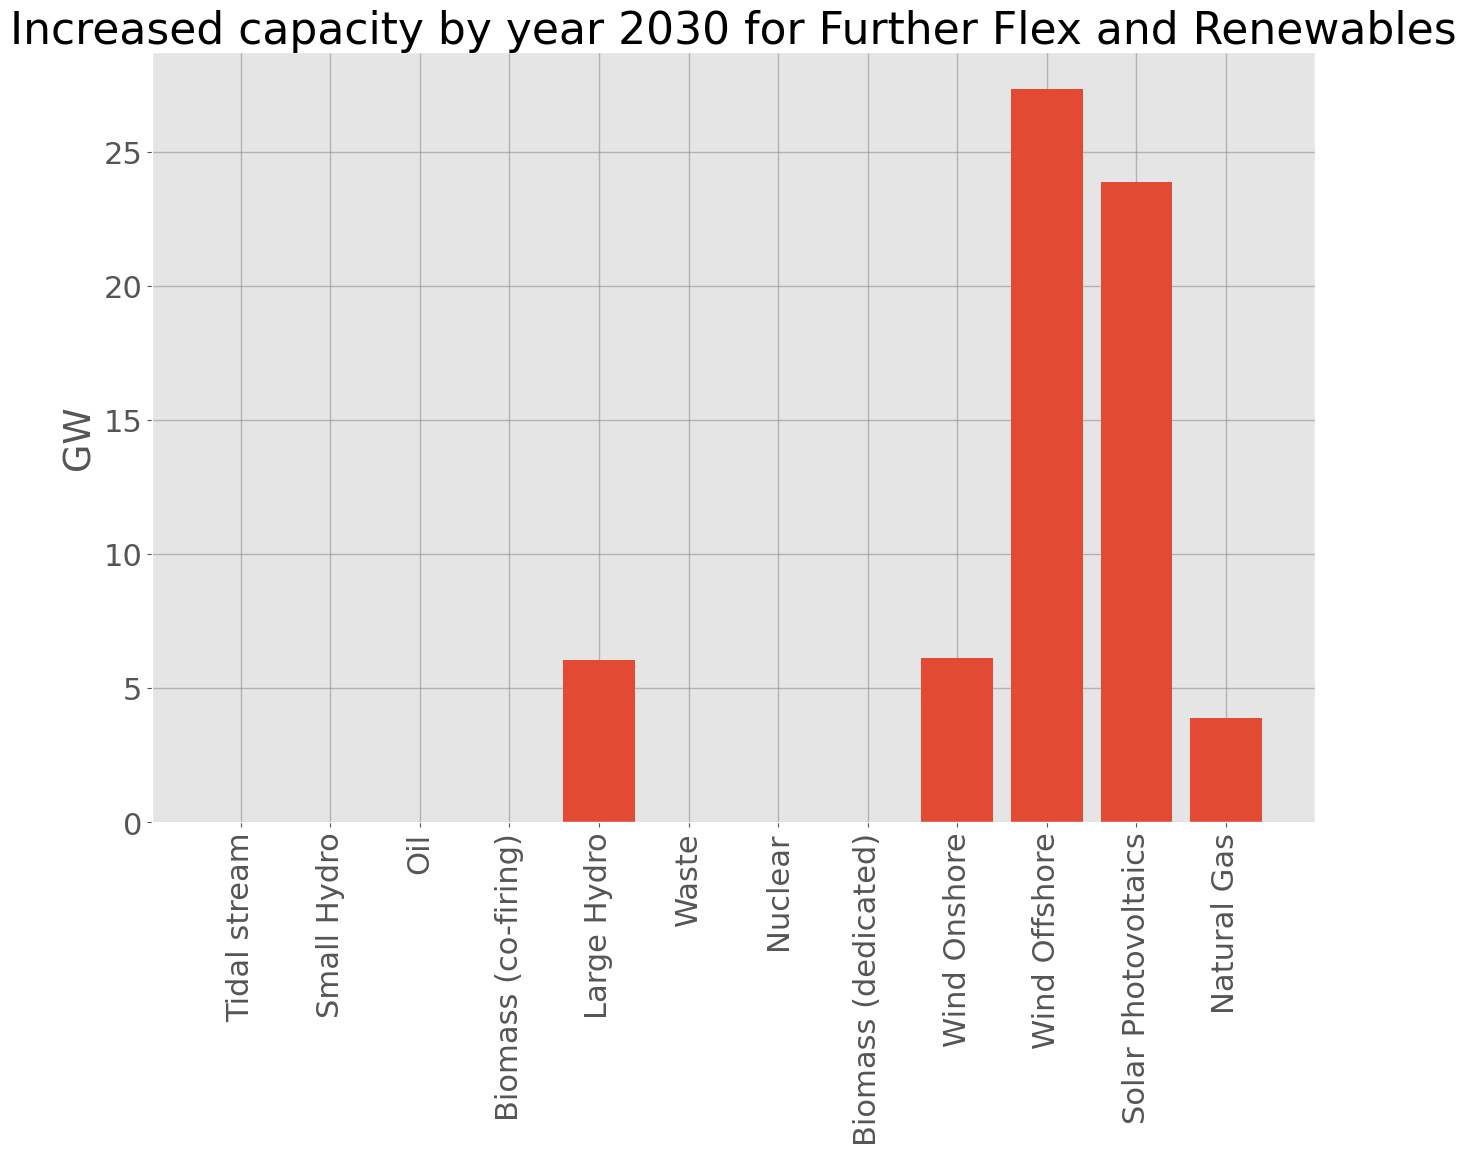

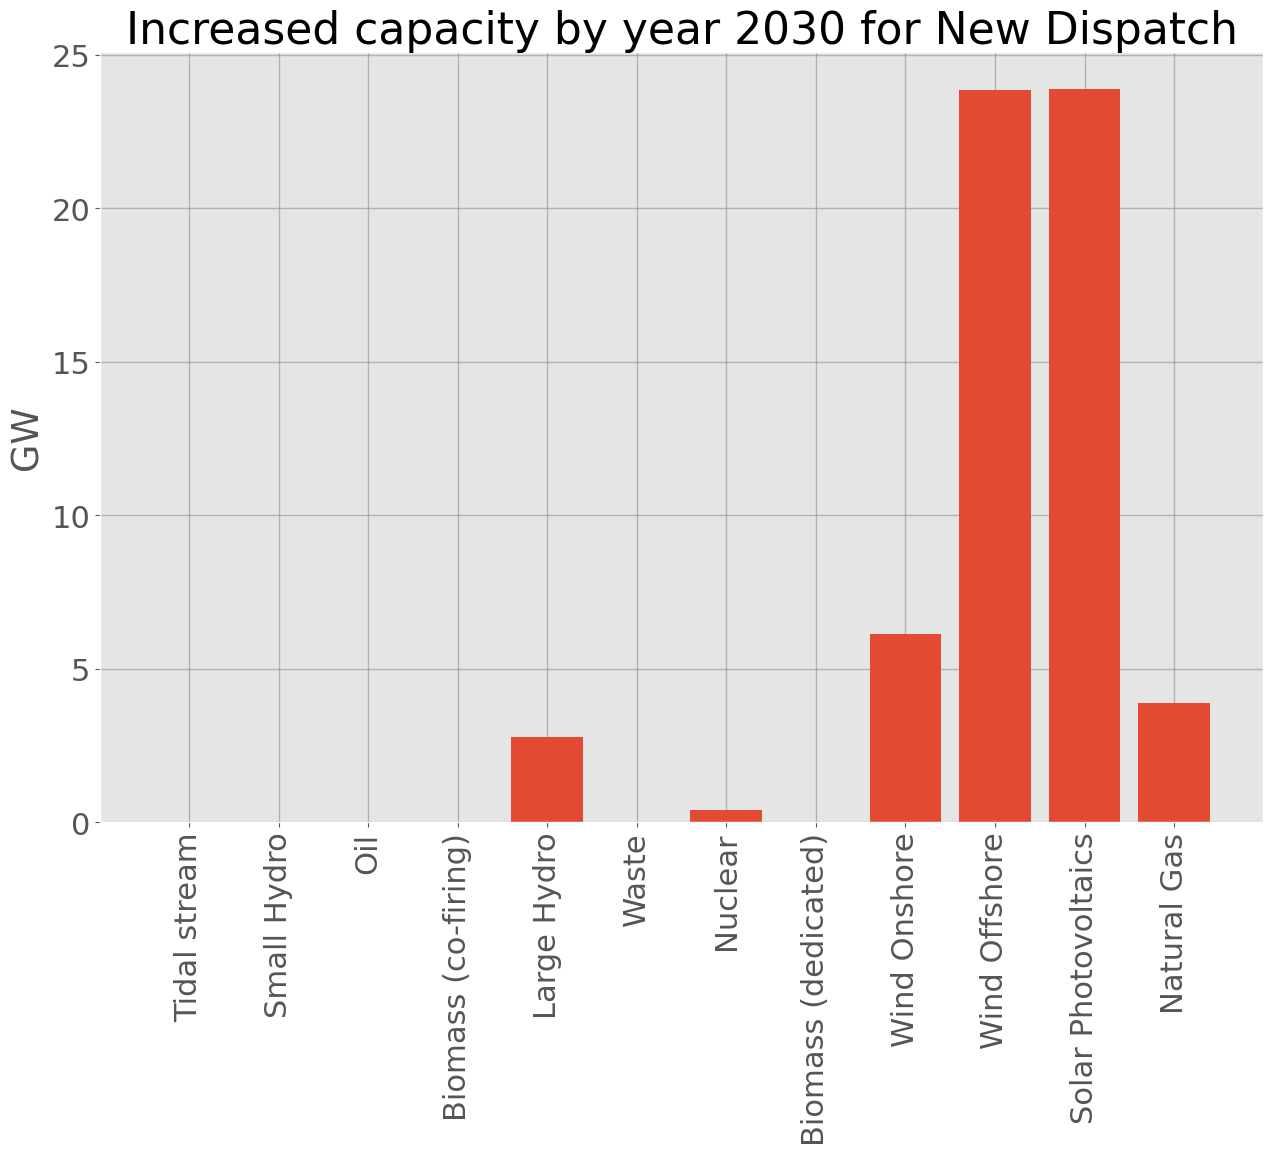

In [11]:
difference_neso = [(df_neso_ffr - gen_p_nom_2025s[0]).clip(lower=0.0),
                   (df_neso_nd - gen_p_nom_2025s[0]).clip(lower=0.0)]

for i in range(len(difference_neso)):
    plt.rcParams.update({'font.size': 22})
    # bar chart
    plt.figure(figsize=(15, 10))
    plt.bar(difference_neso[i].index, difference_neso[i].to_numpy() / 1000)
    plt.xticks(difference_neso[i].index, rotation=90)
    plt.ylabel("GW")
    plt.grid(color="grey", linewidth=1, axis="both", alpha=0.5)
    plt.title("Increased capacity by year " + str(year) + " for " + scenarios[i + 3])
    plt.savefig("C:/Programming/PyPSA-GB_2030/Clean_Power_Analysis" + scenario_names[
        i + 3] + "_increased_capacity_by_year_" + str(year) + ".png",
                format="png", bbox_inches='tight')
    plt.savefig("C:/Programming/PyPSA-GB_2030/Clean_Power_Analysis" + scenario_names[
        i + 3] + "_increased_capacity_by_year_" + str(year) + ".pdf",
                format="pdf", bbox_inches='tight')
    plt.show()

In [28]:
table_data: list[list[str | float]] = [
    ["Solar Photovoltaics", ],
    ["Wind Offshore", ],
    ["Wind Onshore", ],
    ["Biomass (dedicated)", ],
    ["Natural Gas", ],
    ["Nuclear", ]
]

table_data_fuel = [
    ["Biomass (dedicated)", ],
    ["Natural Gas", ],
    ["Nuclear", ],
]

headers = ["Technology", "LTW Cost [B£]", "CT Cost [B£]", "ST Cost [B£]", "FFR Cost [B£]", "ND Cost [B£]", ]
headers_fuel = ["Technology", "LTW Fuel Cost [M£/year]", "CT Fuel Cost [M£/year]", "ST Fuel Cost [M£/year]",
                "FFR Fuel Cost [M£/year]", "ND Fuel Cost [M£/year]"]

solar_cost: float = 0.00
offshore_cost: float = 0.00
onshore_cost: float = 0.00
biomass_cost: float = 0.00
ccgt_cost: float = 0.00
nuclear_cost: float = 0.00

biomass_fuel: float = 0.00
ccgt_fuel: float = 0.00
nuclear_fuel: float = 0.00

for i in range(len(scenarios)):
    difference = difference_fes[i] if i < 3 else difference_neso[i - 3]
    for gen_tech in gen_p_nom_2030s[0].index:
        if gen_tech == "Solar Photovoltaics":
            solar_cost += PV["investment"] * difference["Solar Photovoltaics"]

        if gen_tech == "Wind Offshore":
            offshore_cost += wind_offshore["investment"] * difference["Wind Offshore"]

        if gen_tech == "Wind Onshore":
            onshore_cost += wind_onshore["investment"] * difference["Wind Onshore"]

        if gen_tech == "Biomass (dedicated)":
            biomass_cost += biomass["investment"] * difference["Biomass (dedicated)"]
            biomass_fuel += biomass["fuel"] * biomass["efficiency"] * gen_p_nom_2030s[i][
                "Biomass (dedicated)"] * hours_in_year

        if gen_tech == "Natural Gas":
            ccgt_cost += ccgt["investment"] * difference["Natural Gas"]
            ccgt_fuel += ccgt["fuel"] * ccgt["efficiency"] * gen_p_nom_2030s[i]["Natural Gas"] * hours_in_year

        if gen_tech == "Nuclear":
            nuclear_cost += nuclear["investment"] * difference["Nuclear"]
            nuclear_fuel += nuclear["fuel"] * nuclear["efficiency"] * gen_p_nom_2030s[i]["Nuclear"] * hours_in_year

    solar_cost *= euro_to_gbp
    offshore_cost *= euro_to_gbp
    onshore_cost *= euro_to_gbp
    biomass_cost *= euro_to_gbp
    ccgt_cost *= euro_to_gbp
    nuclear_cost *= euro_to_gbp

    biomass_fuel *= euro_to_gbp
    ccgt_fuel *= euro_to_gbp
    nuclear_fuel *= euro_to_gbp

    table_data[0].append(f"{solar_cost / 1e9:.3f}")
    table_data[1].append(f"{offshore_cost / 1e9:.3f}")
    table_data[2].append(f"{onshore_cost / 1e9:.3f}")
    table_data[3].append(f"{biomass_cost / 1e9:.3f}")
    table_data[4].append(f"{ccgt_cost / 1e9:.3f}")
    table_data[5].append(f"{nuclear_cost / 1e9:.3f}")

    table_data_fuel[0].append(f"{biomass_fuel / 1e6:.3f}")
    table_data_fuel[1].append(f"{ccgt_fuel / 1e6:.3f}")
    table_data_fuel[2].append(f"{nuclear_fuel / 1e6:.3f}")

print(tabulate(table_data, headers=headers, tablefmt="pipe", stralign="center", numalign="center"))  # "grid" format
print("\n")
print(tabulate(table_data_fuel, headers=headers_fuel, tablefmt="pipe", stralign="center",
               numalign="center"))  # "grid" format

|     Technology      |  LTW Cost [B£]  |  CT Cost [B£]  |  ST Cost [B£]  |  FFR Cost [B£]  |  ND Cost [B£]  |
|:-------------------:|:---------------:|:--------------:|:--------------:|:---------------:|:--------------:|
| Solar Photovoltaics |     12.058      |     22.699     |     32.728     |     54.855      |     81.406     |
|    Wind Offshore    |     55.934      |    114.314     |    185.239     |     277.519     |    381.191     |
|    Wind Onshore     |     12.643      |     29.107     |     45.379     |     62.533      |     83.119     |
| Biomass (dedicated) |        0        |     0.946      |     1.135      |      0.536      |     -0.745     |
|     Natural Gas     |        0        |       0        |       0        |      4.102      |     9.024      |
|       Nuclear       |      8.869      |      32.3      |     47.629     |      54.99      |     70.01      |


|     Technology      |  LTW Fuel Cost [M£/year]  |  CT Fuel Cost [M£/year]  |  ST Fuel Cost [M£/year]  |  FFR